## 2.0 Google Analytics Customer Revenue Prediction

### Importing packages

In [1]:
# File system manangement
import os
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Numpy and pandas for data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)
# Importing random for random selections
import random
# Json for importing JSON columns
import json as json
# Pandas io json normalizing
from pandas.io.json import json_normalize
# Scipy stats for statistical analysis
import scipy.stats as stats
# sklearn preprocessing for dealing with categorical features
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
# to use for woe binning for features with a large number of categories
import scorecardpy as sc
# Light gradient boost classifier
from lightgbm import LGBMRegressor
# Sklearn Inputing data spliting method
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# Sklearn importing auc as measurement metric
from sklearn.metrics import mean_squared_error
# Gc memory managment
import gc
# Matplotlib pyplot for plotting
import matplotlib.pyplot as plt
# Seabourne for visualization
import seaborn as sns
sns.set_style('white')

### Importing data

In [2]:
# Setting up package to import data converting JSON columns into individual features

# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
def load_df(csv_path):
    df = pd.read_csv(csv_path, converters={column: json.loads for column in JSON_COLUMNS}\
                     , dtype={'fullVisitorId': 'str', 'visitStartTime': 'str', 'date': 'str'})
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
# Seeting the input and output directory
os.chdir('C:/Users/Jake Cherrie/Documents/Projects/Gstore-Revenue-Prediction')
# Viewing the contained datasets
os.listdir('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction')

['Bins sets',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'trn.csv',
 'tst.csv']

In [14]:
# Importing the training data
trn_df = load_df('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/train.csv')
trn_df['totals.transactionRevenue'].fillna(0, inplace = True)

In [5]:
# Quick view of training data
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null object
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null object
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                90

In [6]:
# Droping features with no information
drp_cols = [col for col in trn_df.columns if trn_df[col].nunique() == 1 & trn_df[col].notnull().values.all()]
trn_df = trn_df.drop(columns=drp_cols)
# Dropping duplicate feature visitStartTime is the same as visitId
trn_df = trn_df.drop(columns='visitId')
# Dropping capaign code as there is ony 1 non-null entry
trn_df = trn_df.drop(columns='trafficSource.campaignCode')
# Noticed that for the training set channelGrouping contains all the information in trafficSource.medium so droping trafficSource.medium
trn_df = trn_df.drop(columns='trafficSource.medium')

In [7]:
# Saving memory by shortning ints and floats
def size_reduction(df):
    int_col     = df.select_dtypes(include=[np.int64]).columns
    flt_col     = df.select_dtypes(include=[np.float64]).columns 
    df[int_col] = df[int_col].astype(np.int32)
    df[flt_col] = df[flt_col].astype(np.float32)
    
size_reduction(trn_df)
gc.collect()

42

In [8]:
trn_df.describe(include='all')

,channelGrouping,date,fullVisitorId,sessionId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.referralPath,trafficSource.source
count,903653,903653,903653,903653,903653.000000,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,450630,903653,703060,903553,11515,10946,21460,21561,21460,21460,21460,903653,274005,400724,330941,903653
unique,8,366,714167,902755,NaN,887159,54,3,2,20,649,6,222,94,28064,376,23,1,274,1,213,5332,44,2,17774,1,8,2,10,1,3659,1475,380
top,Organic Search,20161128,1957458976293878100,3372520850178572500_1492844117,NaN,1493146175,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,1,1,1,1,16990000,Google Merchandise Collection,Google Search,Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3Zd...,False,1,Top,(not set),True,(not provided),/,google
freq,381561,4807,278,2,NaN,8,620364,664479,664530,350072,508229,450377,364744,508229,244881,508229,390657,450630,446754,703060,452522,256,5122,21453,70,21460,21362,20956,865347,274005,366363,75523,400788
mean,NaN,NaN,NaN,NaN,2.264897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,9.283735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Importing the testing data
tst_df = load_df('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/test.csv')

In [10]:
# Quick view of training data
tst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 53 columns):
channelGrouping                                      804684 non-null object
date                                                 804684 non-null object
fullVisitorId                                        804684 non-null object
sessionId                                            804684 non-null object
socialEngagementType                                 804684 non-null object
visitId                                              804684 non-null int64
visitNumber                                          804684 non-null int64
visitStartTime                                       804684 non-null object
device.browser                                       804684 non-null object
device.browserSize                                   804684 non-null object
device.browserVersion                                804684 non-null object
device.deviceCategory                                80

In [11]:
# Droping features with no information
drp_cols = [col for col in tst_df.columns if tst_df[col].nunique() == 1 & tst_df[col].notnull().values.all()]
tst_df = tst_df.drop(columns=drp_cols)
# Dropping duplicate feature visitStartTime is the same as visitId
tst_df = tst_df.drop(columns='visitId')
tst_df = tst_df.drop(columns='trafficSource.medium')

size_reduction(tst_df)
gc.collect()

35

In [12]:
tst_df.describe(include='all')

,channelGrouping,date,fullVisitorId,sessionId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.referralPath,trafficSource.source
count,804684,804684,804684,804684,804684.000000,804684,804684,804684,804684,804684,804684,804684,804684,804684,804684,804684,804684,420948,804684,604370,804545,53791,53814,53862,53814,53814,53814,804684,260513,413652,235323,804684
unique,8,272,617242,803863,NaN,780264,109,3,2,22,732,6,219,109,25750,376,23,1,229,1,160,51,3,41317,1,10,3,31,1,2415,2197,324
top,Organic Search,20171212,7282998257608986241,5793513726556402779_1524380381,NaN,1513125098,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,1,1,1,1,Google Merchandise Store,Content,CN_Whvvc_9UCFd6LswodGTgKCQ,False,1,RHS,(not set),True,(not provided),/,google
freq,357402,9234,272,2,NaN,28,552692,507100,507140,269648,424730,427026,352473,424730,254168,424730,377688,420948,417310,604370,423806,39566,42223,74,53814,52551,42246,728927,260513,346391,62770,417104
mean,NaN,NaN,NaN,NaN,2.414087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,9.431737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Saving Data for Quick Loads and Debugging

In [15]:
trn_df.to_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/trn.csv', index=False)
tst_df.to_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/tst.csv', index=False)

In [16]:
# Seting up debugging sets for quicker exploration
debugTrn = sorted(random.sample(range(1,903653),903653-200000))
debugTst = sorted(random.sample(range(1,804684),804684-100000))

In [122]:
trn_df = pd.read_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/trn.csv'\
           , dtype={'fullVisitorId': 'str', 'visitStartTime': 'str', 'date': 'str'}, skiprows=debugTrn)
tst_df = pd.read_csv('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/tst.csv'\
           , dtype={'fullVisitorId': 'str', 'visitStartTime': 'str', 'date': 'str'}, skiprows=debugTst)
gc.collect()

784

### Creating New Combination Features

In [123]:
# Setting up a has revenue flag
trn_df['hasRevenue'] = (trn_df['totals.transactionRevenue'] > 0).astype(int)
trn_df['logRevenue'] = np.log1p(trn_df['totals.transactionRevenue'])

### Creating Time Features

In [124]:
#Looking at first and last shows that it is clearly a time dependent problem
trn_df['visitStartTime'] = pd.to_datetime(trn_df['visitStartTime'],unit='s')
print(trn_df['visitStartTime'].describe())
tst_df['visitStartTime'] = pd.to_datetime(tst_df['visitStartTime'],unit='s')
print(tst_df['visitStartTime'].describe())
# should explore weighting the more ecent data lgb(weight=w)
trn_df['weight'] = 1

count                  200000
unique                 199195
top       2017-03-13 07:31:36
freq                        4
first     2016-08-01 07:04:26
last      2017-08-02 06:59:46
Name: visitStartTime, dtype: object
count                  100000
unique                  99365
top       2017-12-13 00:29:17
freq                        6
first     2017-08-02 07:01:41
last      2018-05-01 06:56:00
Name: visitStartTime, dtype: object


In [125]:
trn_df['weekday'] = trn_df['visitStartTime'].dt.weekday.astype(str)
tst_df['weekday'] = tst_df['visitStartTime'].dt.weekday.astype(str)

In [126]:
trn_df['time']  = trn_df['visitStartTime'].dt.hour.astype(str)
tst_df['time']  = tst_df['visitStartTime'].dt.hour.astype(str)

### Encoding Categorical Features

In [127]:
trn_X = trn_df[tst_df.columns]
trn_y = trn_df['logRevenue']

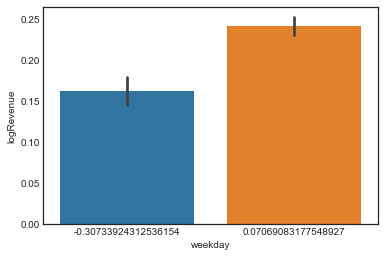

In [78]:
# Plotting the weekday relationship to the log1p revenue
sns.barplot('weekday', 'logRevenue', data = trn_df)

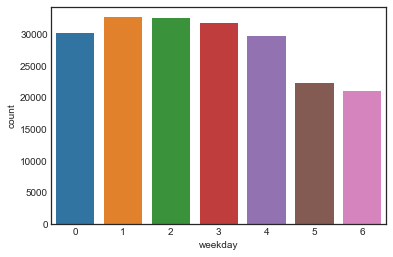

In [73]:
# Ploting count per group
sns.countplot('weekday', data=trn_df)

In [107]:
# Weight of Evidence (WOE) encoding
weekday = trn_df[['weekday','hasRevenue']]
#bins_weekday = sc.woebin(weekday, y='hasRevenue', stop_limit=0.02, max_num_bin=2, method='tree')
#Saving for quick load    
#np.save('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/Bins sets/bins_weekday.npy', bins_weekday) 
# Quick load of dataframe
bins_weekday = np.load('C:/Users/Jake Cherrie/Data Sets/Gstore Revenue Prediction/Bins sets/bins_weekday.npy').item()
bins_weekday

{'weekday':   variable                bin   count  count_distr    good   bad   badprob  \
 0  weekday              6%,%5   43218      0.21609   42817   401  0.009279   
 1  weekday  2%,%3%,%0%,%4%,%1  156782      0.78391  154668  2114  0.013484   
 
         woe    bin_iv  total_iv             breaks  is_special_values  
 0 -0.307339  0.017631  0.021687              6%,%5              False  
 1  0.070691  0.004055  0.021687  2%,%3%,%0%,%4%,%1              False  }

In [75]:
# Applying WOE encoding
trn_df['weekday'] = sc.woebin_ply(trn_df, bins_weekday)['weekday_woe']
tst_df['weekday'] = sc.woebin_ply(tst_df, bins_weekday)['weekday_woe']

C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:14: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: weight)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:20: UserWarning: There are 1 date/time type columns are removed from input dataset. 
 (ColumnNames: visitStartTime)
  warnings.warn("There are {} date/time type columns are removed from input dataset. \n (ColumnNames: {})".format(len(datetime_cols), ', '.join(datetime_cols)))
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:20: UserWarning: There are 1 date/time type columns are removed from input dataset. 
 (ColumnNames: visitStartTime)
  warnings.warn("There are {} date/time type columns are removed from input dataset.

In [128]:
#Dropping unused features
trn_X = trn_X.drop(columns=['fullVisitorId', 'visitStartTime', 'date', 'sessionId'])
tst_X = tst_df.drop(columns=['fullVisitorId', 'visitStartTime', 'date', 'sessionId'])
#Setting up categorical columns
cat_col = [col for col in trn_X.columns if trn_X[col].dtype == 'object']
# factorizing categorical columns

In [129]:
for col in cat_col:
    indexer = pd.factorize(trn_X[col])[1]
    trn_X[col] = indexer.get_indexer(trn_X[col])
    tst_X[col] = indexer.get_indexer(tst_X[col])

In [130]:
trn_X.describe()

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.referralPath,trafficSource.source,weekday,time
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,100254.0,200000.000000,155560.0,199975.000000,200000.000000,200000.000000,200000.000000,200000.000000,4726.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000
mean,2.135500,2.278840,1.891430,0.296315,2.153330,22.263545,1.336370,26.223460,1.56668,713.405735,14.889535,4.494255,1.0,4.592195,1.0,3.846056,-0.909685,-0.976365,50.792420,-0.976370,1.007829,-0.975875,0.082680,-0.695475,4.496790,11.533850,6.869785,3.17591,11.571860
std,2.445248,9.376402,1.840951,0.524189,1.233863,55.462771,0.932395,18.345494,4.30954,1902.965284,33.622341,2.894365,0.0,9.752038,0.0,7.119468,0.925447,0.151942,387.188141,0.151894,0.229428,0.156630,0.456448,0.460207,54.573898,42.478148,9.979910,1.99769,6.768583
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,1.000000,1.0,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.00000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,21.000000,0.00000,4.000000,0.000000,4.000000,1.0,1.000000,1.0,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.00000,6.000000
50%,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,2.000000,24.000000,0.00000,35.000000,0.000000,4.000000,1.0,2.000000,1.0,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,6.000000,3.00000,12.000000
75%,5.000000,1.000000,3.000000,1.000000,3.000000,18.000000,2.000000,29.000000,1.00000,268.000000,12.000000,6.000000,1.0,4.000000,1.0,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,13.000000,16.000000,5.00000,17.000000
max,7.000000,395.000000,33.000000,2.000000,14.000000,611.000000,5.000000,201.000000,89.00000,11923.000000,367.000000,22.000000,1.0,500.000000,1.0,466.000000,32.000000,1.000000,4458.000000,0.000000,14.000000,1.000000,8.000000,0.000000,1157.000000,760.000000,215.000000,6.00000,23.000000
